[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/langchain/rag-chatbot.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/langchain/rag-chatbot.ipynb)

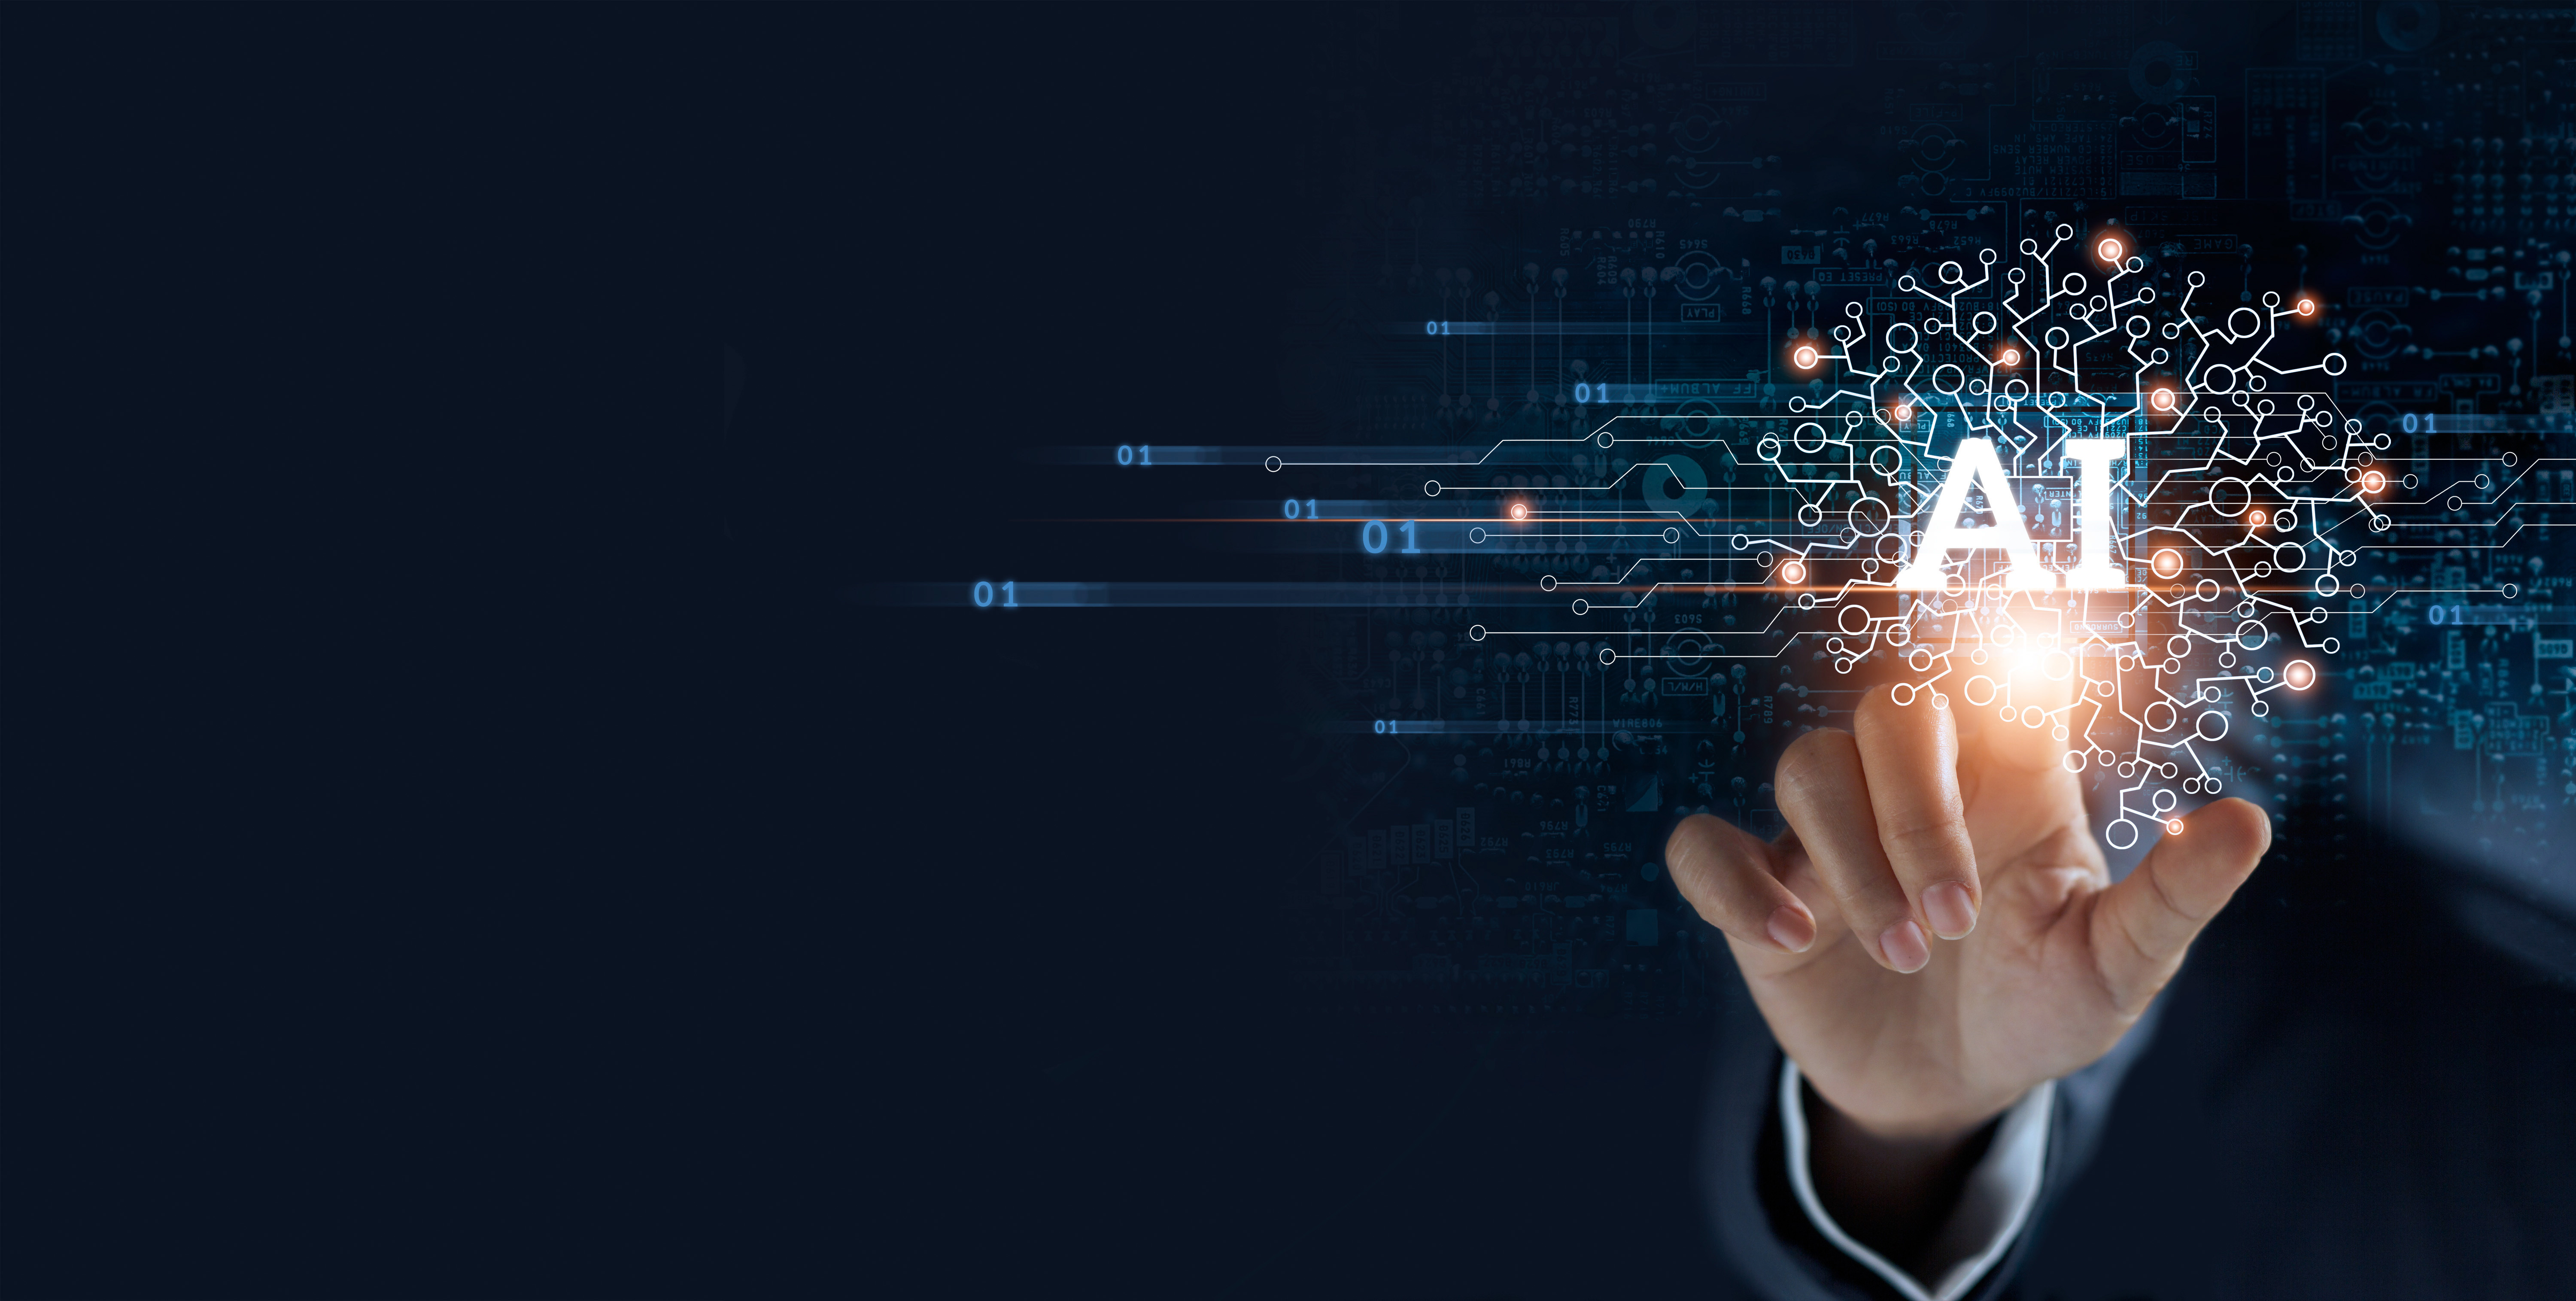

# Aparavi x Weaviate x FriendliAi - Enterprise Challenge

Welcome! You made it. We are excited to see what exciting projects you will build with our software...

This is the Enterprise UI challenge using the [Weaviate Vector Database Integration](https://weaviate.io/).

### A Few Things to Consider

- **Start small and extend**: There's only a little time, so begin with a manageable project and expand as you go.
- **Mind your hardware limitations**: If you have limited memory and processing power, try using a subset of our sample data or upload your own. It's a hackathon; your proof of concept will be amazing no matter the size of the dataset—quality is what matters.
- **Be selective with vectorization**: The point of the challenge is to identify only the important documents, so consider not vectorizing everything.

## Resources

- **Sample Data Set**: Includes HR, Finance, Legal, and Health documents to help you build powerful enterprise agents. Download or connect to it [here](https://drive.google.com/drive/folders/1ZJGnsWw64Z1edZZkzGUZXkENJD2lo6as?usp=drive_link)
- **Aparavi Mac or Windows OS Installer**: Get it 
- **Quick Installer Guide**: View it here to get your platform running: [here](https://github.com/AparaviSoftware/GithubHackNight/tree/main)
- **Technical Documentation**: Access more resources here: [Aparavi Academy - Getting Started](https://aparavi-academy.eu/en/getting-started)

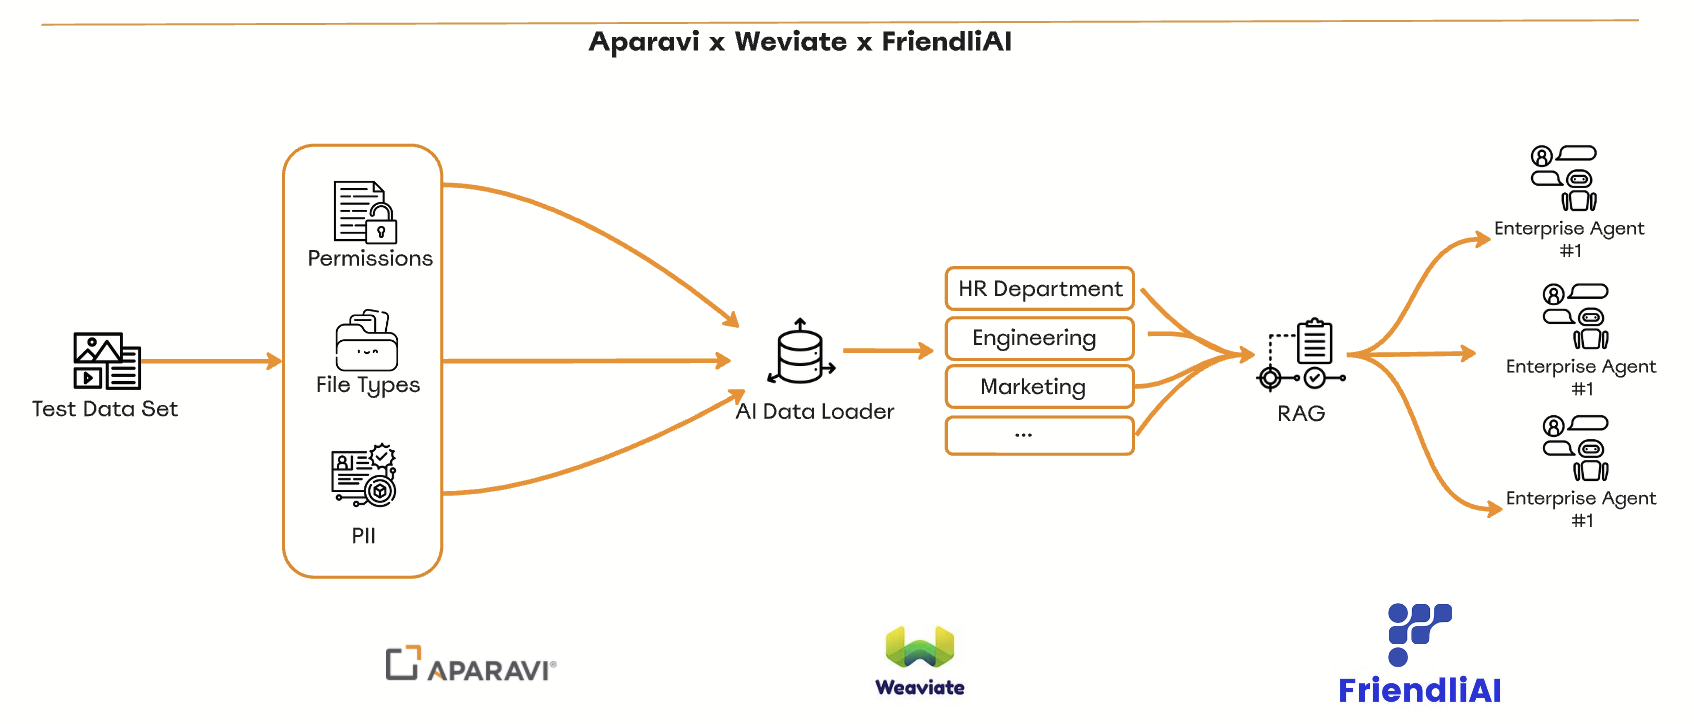

### Scan, Classify and Curate your data first!

Before jumping into the fun GenAI stuff, be sure to carefully curate the data so that you only load the right information into the weaviate vector DB (also note that depending on your time and hardware restraints, embedding large amounts of unstrucured data might take a while).

Follow the easy [Quick Start Guide](https://github.com/AparaviSoftware/GithubHackNight/blob/main/QuickStartGuide_ScanClassifyTag.ipynb) to get going fast! 

## Populate a Weaviate Vector Data Base

It's show time, you have sorted through your data, understood permissions and file ownership of it but more importantly you have run classifications to sort through you documents and identified which critical files are needed for your GenAI application and which you may rather leave out since they contain PII or other sensitive information. 

Now use this [Quick Start Guide - Weaviate](https://github.com/AparaviSoftware/GithubHackNight/blob/main/QuickStartGuide_WeaviateIntegration.ipynb) to either populate a cloud instance or a docker container locally. 

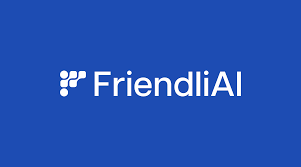

## Use the FirendliAi Serverless API to do inference on open-source models 

Customize the code to your needs, optionally also integrating a local docker deployment for more security

In [ ]:
import json
from openai import OpenAI
import gradio as gr
from getpass import getpass

import weaviate
from weaviate.classes.init import Auth
from weaviate.classes.config import Configure

wcd_url = getpass("WCD_DEMO_URL:")
wcd_api_key = getpass("WCD_DEMO_KEY:")
openai_api_key = getpass("OPENAI_API_KEY:")
friendli_token = getpass("FRIENDLI_TOKEN:")

# Instantiate the weaviate client
client = weaviate.connect_to_weaviate_cloud(
    cluster_url=wcd_url,
    auth_credentials=Auth.api_key(wcd_api_key),
    headers={
        "X-Openai-Api-Key": openai_api_key,
        "X-Friendli-Token": friendli_token
    }
)

# Prepare a collection for the agent (Fix here please Hendrik)
try:
    film_collections = client.collections.get("FILM")
except Exception as e:
    film_collections = client.collections.create(
        "FILM",
        generative_config=Configure.Generative.friendliai(
            model="meta-llama-3.1-70b-instruct"
        ),
        vectorizer_config=[
            Configure.NamedVectors.text2vec_openai(
                name="category_vector",
                source_properties=["Category"]
            )
        ]
    )
    question_objs = list()
    with open("jeopardy_tiny.json") as json_data:
        data = json.load(json_data)
        for i, d in enumerate(data):
            question_objs.append({
                "answer": d["Answer"],
                "question": d["Question"],
                "category": d["Category"],
            })
        film_collections.data.insert_many(question_objs)

friendli_client = OpenAI(
    base_url="https://inference.friendli.ai/v1",
    api_key=friendli_token
)

friendli_search_client = OpenAI(
    base_url="https://inference.friendli.ai/tools/v1",
    api_key=friendli_token
)

def chat_function(message, history):
    messages = []
    for user, chatbot in history:
        messages.append({"role" : "user", "content": user})
        messages.append({"role" : "assistant", "content": chatbot})
    messages.append({"role": "user", "content": message})

    tools=[
        {
            "type": "function",
            "function": {
            "name": "execute_action",
            "description": "Execute an action based on the question.",
                "parameters": {
                "type": "object",
                "properties": {
                    "action": {
                        "type": "string",
                        "enum": ["RAG", "WebSearch", "Response"],
                        "description": "The action to take for the question."
                    },
                },
            },
            },
        },
    ]

    tool_response = friendli_client.chat.completions.create(
        model="meta-llama-3.1-70b-instruct",
        messages=messages,
        tools=tools,
        temperature=0,
        frequency_penalty=1,
    )
    func_kwargs = json.loads(tool_response.choices[0].message.tool_calls[0].function.arguments)
    action = func_kwargs["action"]

    if action == "RAG":
        print(f"RAG for the message: {message}")
        response = film_collections.generate.near_text(
            query=message,
            grouped_task="Write an intriguing introduction to the films.",
            limit=2
        )
        yield response.generated
    elif action == "WebSearch":
        print(f"WebSearch for the message: {message}")
        stream = friendli_search_client.chat.completions.create(
            model="meta-llama-3.1-70b-instruct",
            messages=messages,
            stream=True,
            tools=[{"type": "web:search"}],
        )
        res = ""
        for chunk in stream:
            if chunk.choices is None:
                yield "Waiting for tool response..."
            else:
                res += chunk.choices[0].delta.content or ""
                yield res
    else:
        print(f"Plain response for the message: {message}")
        stream = friendli_client.chat.completions.create(
            model="meta-llama-3.1-70b-instruct",
            messages=messages,
            stream=True,
        )
        res = ""
        for chunk in stream:
            if chunk.choices is not None:
                res += chunk.choices[0].delta.content or ""
                yield res

css = """
.gradio-container {
    max-width: 800px !important;
    margin-top: 100px !important;
}
.pending {
    display: none !important;
}
.sm {
    box-shadow: None !important;
}
#component-2 {
    height: 400px !important;
}
"""

with gr.Blocks(theme=gr.themes.Soft(), css=css) as agent:
    gr.ChatInterface(chat_function)
agent.launch()